__Kaggle competition - Titanic survivorship__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Categorical feature EDA](#Categorical-feature-EDA)
    1. [numeric feature EDA](#numeric-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Engineering](#Engineering)
    1. [Encoding](#Encoding)
    1. [Transformation](#Transformation)
        1. [Polynomial features](#Polynomial-features)
        1. [Skew](#Skew)
        1. [Scale](#Scale)
    1. [Outliers](#Outliers)
1. [Feature importance](#Feature-importance)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
    1. [Submission - standard models](#Submission-standard-models)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Submission - stacked models](#Submission-stacked-models)    

# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from functools import reduce
import time; rundate = time.strftime("%Y%m%d")

import warnings
warnings.simplefilter("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd
pd.set_option("display.max_rows", 500); pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.datasets as datasets
import sklearn.ensemble as ensemble
import sklearn.impute as impute
import sklearn.linear_model as linear_model
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm

import lightgbm
import xgboost

from hyperopt import hp

import eif
import shap
shap.initjs()
# from eli5.sklearn import PermutationImportance
# from pdpbox import pdp, get_dataset, info_plots

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import category_encoders as ce

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    import mlmachine.data as data
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PlayWithPandas,
        UnprocessedColumnAdder,
        KFoldTargetEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

c:\users\petersont\appdata\local\continuum\anaconda3\envs\petersont\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data

<a id = 'Data'></a>

In [2]:
# load data and print dimensions
df_train, df_valid = data.titanic()
# df_train = pd.read_csv("s3://tdp-ml-datasets/kaggle-titanic/train.csv")
# df_valid = pd.read_csv("s3://tdp-ml-datasets/kaggle-titanic/test.csv")

print("Training data dimensions: {}".format(df_train.shape))
print("Validation data dimensions: {}".format(df_valid.shape))

Training data dimensions: (891, 12)
Validation data dimensions: (418, 11)


In [3]:
# display info and first 5 rows
df_train.info()
display(df_train[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,NaN,S


In [4]:
# review counts of different column types
df_train.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [5]:
# Load training data into mlmachine
train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    force_to_categorical=["Pclass","SibSp","Parch"],
    target_type="categorical",
)
print(train.data.shape)

******************
_categorical label encoding

0 __> 0
1 __> 1
(891, 9)


In [6]:
# load training data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    force_to_categorical=["Pclass","SibSp","Parch"],
)
print(valid.data.shape)

(418, 9)


# EDA

<a id = 'EDA'></a>

## Categorical feature EDA

<a id = 'Categorical-feature-EDA'></a>

##### Univariate & feature vs. target

univariate summary biivariate summary 
 
 
 Pclass 
 count 
 proportion 
 
 
 
 
 3.000000 
 491.000000 
 55.106622 
 
 
 1.000000 
 216.000000 
 24.242424 
 
 
 2.000000 
 184.000000 
 20.650954 
 
 
 
 
 
 Pclass 
 0 
 1 
 percent_positive 
 
 
 
 
 1 
 80 
 136 
 62.962963 
 
 
 2 
 97 
 87 
 47.282609 
 
 
 3 
 372 
 119 
 24.236253

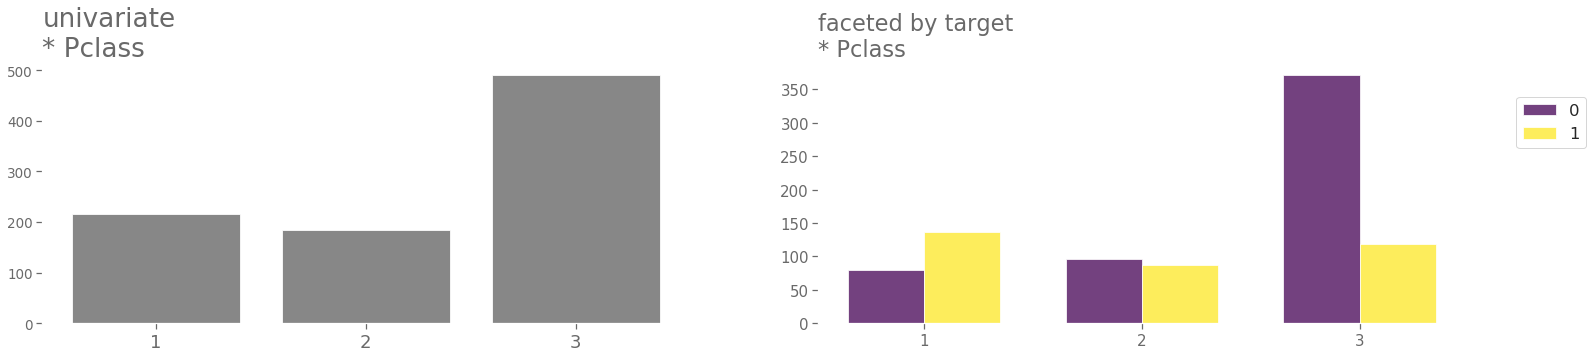

univariate summary biivariate summary 
 
 
 SibSp 
 count 
 proportion 
 
 
 
 
 0.000000 
 608.000000 
 68.237935 
 
 
 1.000000 
 209.000000 
 23.456790 
 
 
 2.000000 
 28.000000 
 3.142536 
 
 
 4.000000 
 18.000000 
 2.020202 
 
 
 3.000000 
 16.000000 
 1.795735 
 
 
 8.000000 
 7.000000 
 0.785634 
 
 
 5.000000 
 5.000000 
 0.561167 
 
 
 
 
 
 SibSp 
 0 
 1 
 percent_positive 
 
 
 
 
 0 
 398.000000 
 210.000000 
 34.539474 
 
 
 1 
 97.000000 
 112.000000 
 53.588517 
 
 
 2 
 15.000000 
 13.000000 
 46.428571 
 
 
 3 
 12.000000 
 4.000000 
 25.000000 
 
 
 4 
 15.000000 
 3.000000 
 16.666667 
 
 
 5 
 5.000000 
 nan 
 nan 
 
 
 8 
 7.000000 
 nan 
 nan

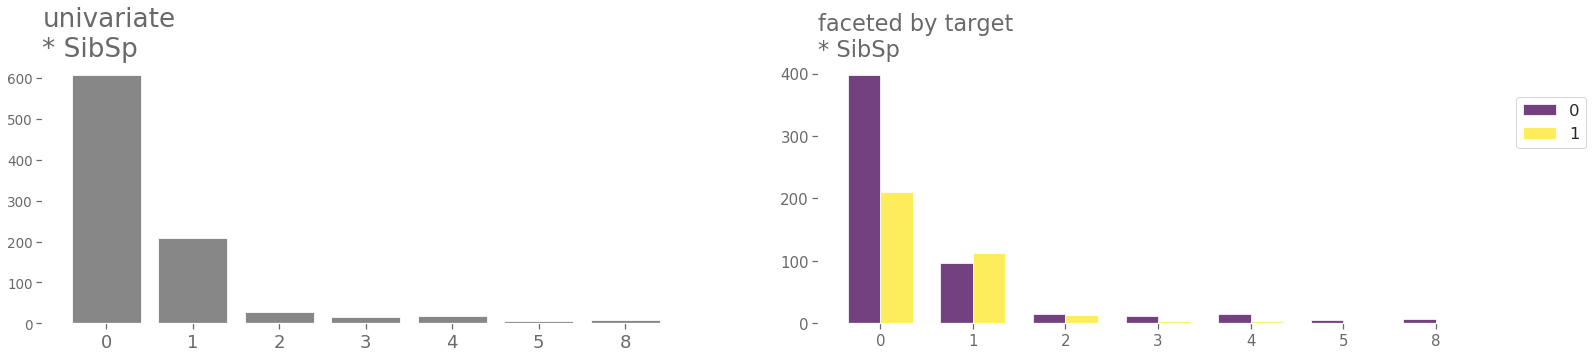

univariate summary biivariate summary 
 
 
 Parch 
 count 
 proportion 
 
 
 
 
 0.000000 
 678.000000 
 76.094276 
 
 
 1.000000 
 118.000000 
 13.243547 
 
 
 2.000000 
 80.000000 
 8.978676 
 
 
 3.000000 
 5.000000 
 0.561167 
 
 
 5.000000 
 5.000000 
 0.561167 
 
 
 4.000000 
 4.000000 
 0.448934 
 
 
 6.000000 
 1.000000 
 0.112233 
 
 
 
 
 
 Parch 
 0 
 1 
 percent_positive 
 
 
 
 
 0 
 445.000000 
 233.000000 
 34.365782 
 
 
 1 
 53.000000 
 65.000000 
 55.084746 
 
 
 2 
 40.000000 
 40.000000 
 50.000000 
 
 
 3 
 2.000000 
 3.000000 
 60.000000 
 
 
 4 
 4.000000 
 nan 
 nan 
 
 
 5 
 4.000000 
 1.000000 
 20.000000 
 
 
 6 
 1.000000 
 nan 
 nan

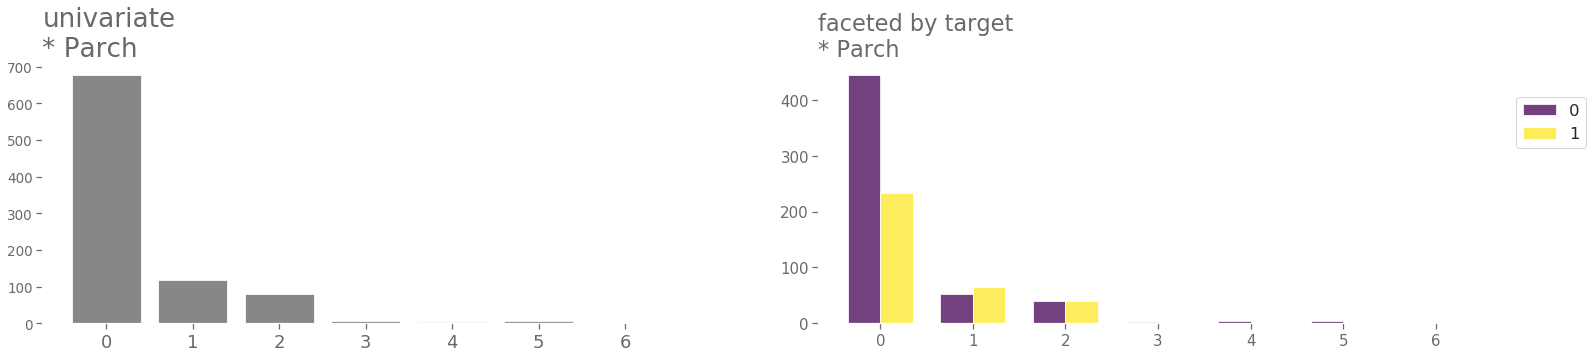

univariate summary biivariate summary statistical test 
 
 
 Sex 
 count 
 proportion 
 
 
 
 
 male 
 577 
 64.758698 
 
 
 female 
 314 
 35.241302 
 
 
 
 
 
 Sex 
 0 
 1 
 percent_positive 
 
 
 
 
 female 
 81 
 233 
 74.203822 
 
 
 male 
 468 
 109 
 18.890815 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 16.218800 
 0.000000

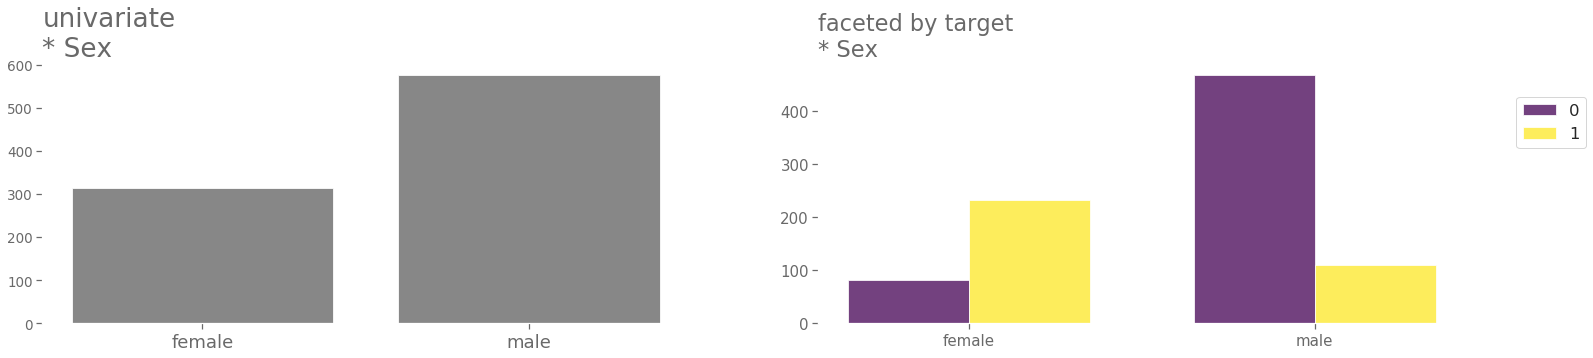

univariate summary biivariate summary 
 
 
 Embarked 
 count 
 proportion 
 
 
 
 
 S 
 644 
 72.440945 
 
 
 C 
 168 
 18.897638 
 
 
 Q 
 77 
 8.661417 
 
 
 
 
 
 Embarked 
 0 
 1 
 percent_positive 
 
 
 
 
 C 
 75 
 93 
 55.357143 
 
 
 Q 
 47 
 30 
 38.961039 
 
 
 S 
 427 
 217 
 33.695652

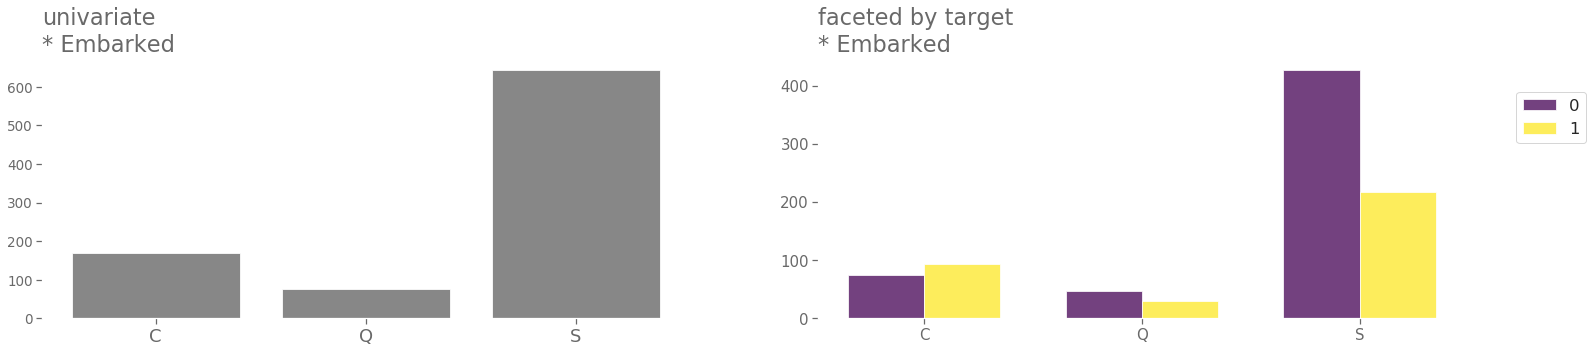

In [7]:
# categorical features
for feature in train.feature_type["categorical"]:
    train.eda_cat_target_cat_feat(feature=feature, level_count_cap=50)

## numeric feature EDA

<a id = 'numeric-feature-EDA'></a>

##### Univariate & feature vs. target

univariate stats bivariate stats statistical test 
 
 
 
 Age 
 
 
 
 
 count 
 714.000000 
 
 
 mean 
 29.699118 
 
 
 std 
 14.526497 
 
 
 min 
 0.420000 
 
 
 25% 
 20.125000 
 
 
 50% 
 28.000000 
 
 
 75% 
 38.000000 
 
 
 max 
 80.000000 
 
 
 skew 
 0.388290 
 
 
 kurtosis 
 0.168637 
 
 
 
 
 
 Age 
 count 
 proportion 
 mean 
 std_dv 
 
 
 
 
 0.000000 
 549.000000 
 61.616162 
 30.626179 
 14.155388 
 
 
 1.000000 
 342.000000 
 38.383838 
 28.343690 
 14.925152 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 2.066700 
 0.038800

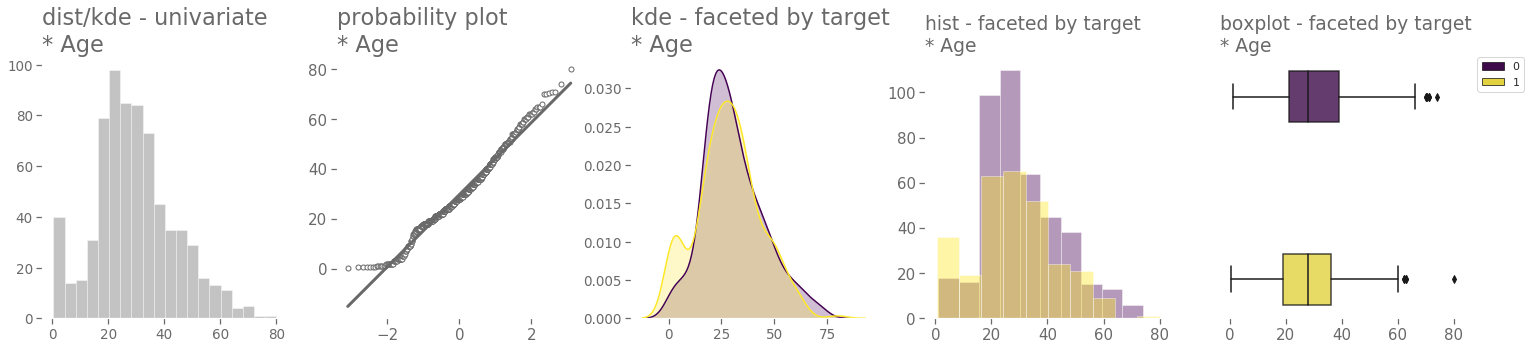

univariate stats bivariate stats statistical test 
 
 
 
 Fare 
 
 
 
 
 count 
 891.000000 
 
 
 mean 
 32.204208 
 
 
 std 
 49.693429 
 
 
 min 
 0.000000 
 
 
 25% 
 7.910400 
 
 
 50% 
 14.454200 
 
 
 75% 
 31.000000 
 
 
 max 
 512.329200 
 
 
 skew 
 4.779250 
 
 
 kurtosis 
 33.204289 
 
 
 
 
 
 Fare 
 count 
 proportion 
 mean 
 std_dv 
 
 
 
 
 0.000000 
 549.000000 
 61.616162 
 22.117887 
 31.359607 
 
 
 1.000000 
 342.000000 
 38.383838 
 48.395408 
 66.499563 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -7.939200 
 0.000000

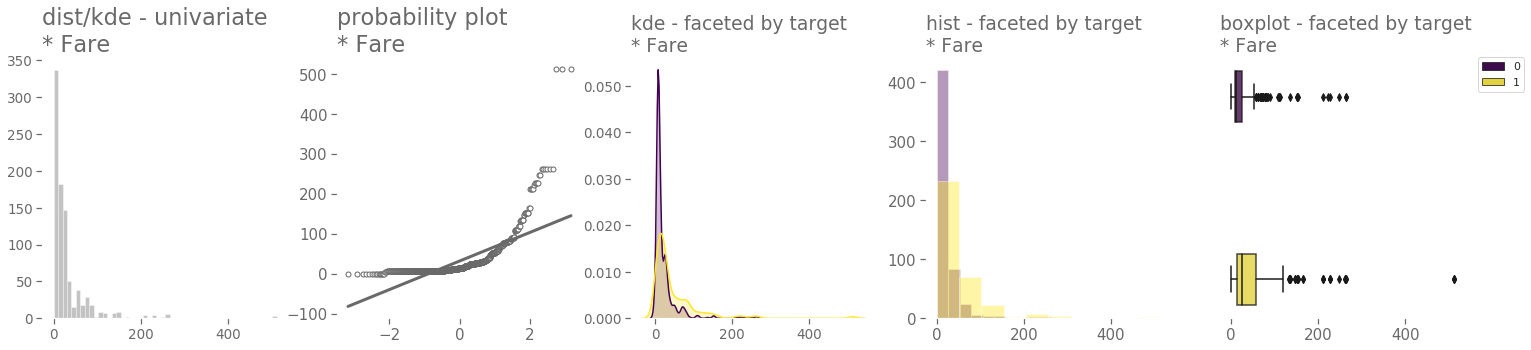

In [8]:
# numeric features
for feature in train.feature_type["numeric"]:
    train.eda_cat_target_num_feat(feature=feature)

##### Correlation

###### Correlation (all samples)

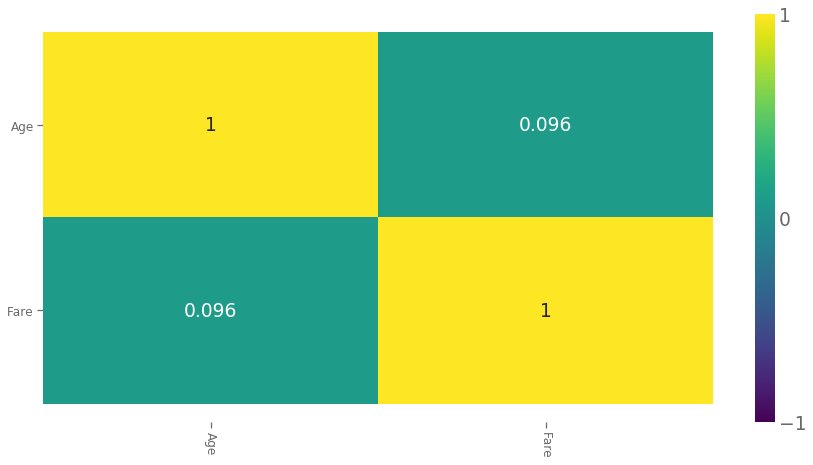

In [9]:
# correlation heat map
p = PrettierPlot()
ax = p.make_canvas()
p.pretty_corr_heatmap(df=train.data, annot=True, ax=ax)

###### Correlation (top vs. target)

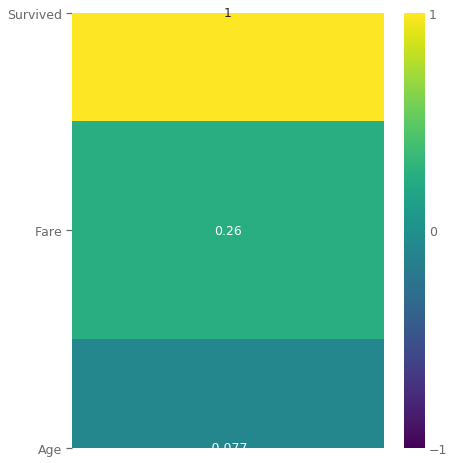

In [10]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_prop=10)
ax = p.make_canvas()
p.pretty_corr_heatmap_target(
    df=train.data, target=train.target, thresh=0.01, annot=True, ax=ax
)

##### Pair plot

<a id = 'Pair-plot'></a>

In [11]:
# # pair plot
# p = PrettierPlot(chart_prop=12)
# p.pretty_pair_plot(df=train.data[["Age","Fare","Sex","Pclass","Embarked"]].dropna(), diag_kind="auto")

In [12]:
# # pair plot
# p = PrettierPlot(chart_prop=12)
# p.pretty_pair_plot(
#     df=train.data.dropna(),
#     diag_kind="kde",
#     target=train.target,
#     cols=["Age", "Fare", "Pclass", "Parch", "SibSp"],
#     legend_labels=["Died", "Survived"],
#     bbox=(2.0, 0.0),
# )

## Faceting

<a id = 'Faceting'></a>

##### Categorical by categorical

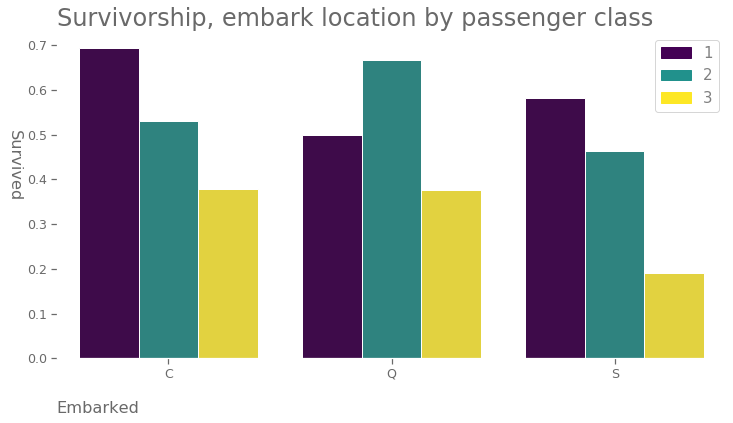

In [13]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_prop=12)
ax = p.make_canvas(title="Survivorship, embark location by passenger class", y_shift=0.7)
p.pretty_facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    y_units="ff",
    ax=ax,
)

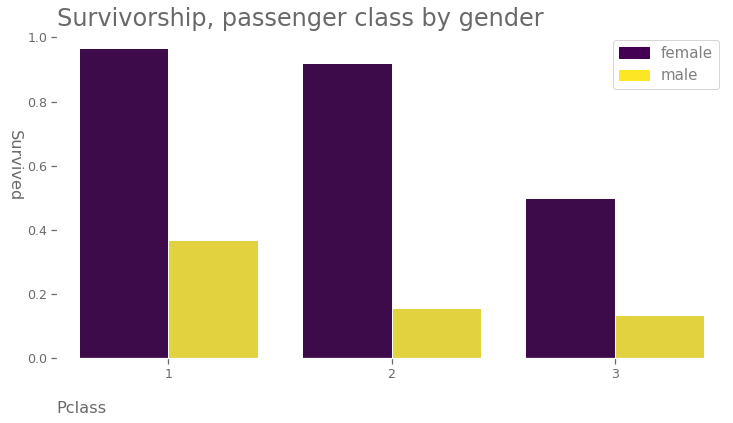

In [14]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_prop=12)
ax = p.make_canvas(title="Survivorship, passenger class by gender", y_shift=0.7)
p.pretty_facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Pclass",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

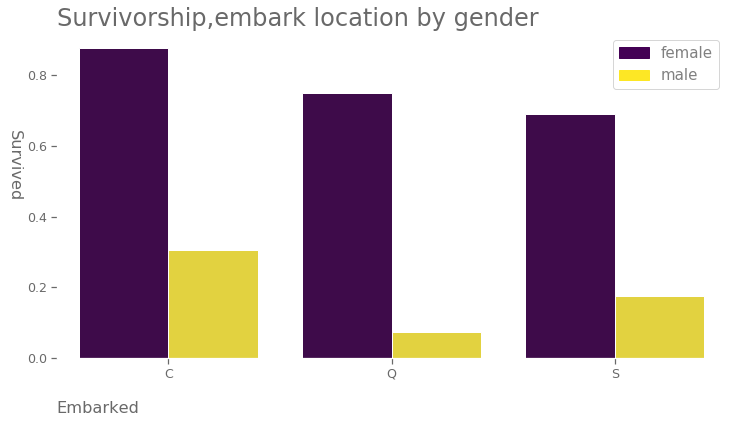

In [15]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_prop=12)
ax = p.make_canvas(title="Survivorship,embark location by gender", y_shift=0.7)
p.pretty_facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

<Figure size 1080x540 with 0 Axes>

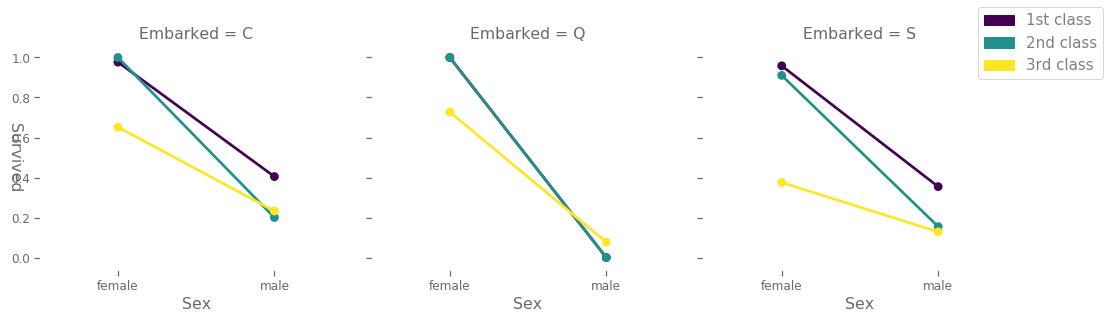

In [16]:
#
p = PrettierPlot()
p.pretty_facet_two_cat_point(
    df=train.recombine_data(train.data, train.target),
    x="Sex",
    y=train.target.name,
    split="Pclass",
    cat_col="Embarked",
    aspect=1.0,
    height=5,
    bbox=(1.3, 1.2),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

<Figure size 1080x540 with 0 Axes>

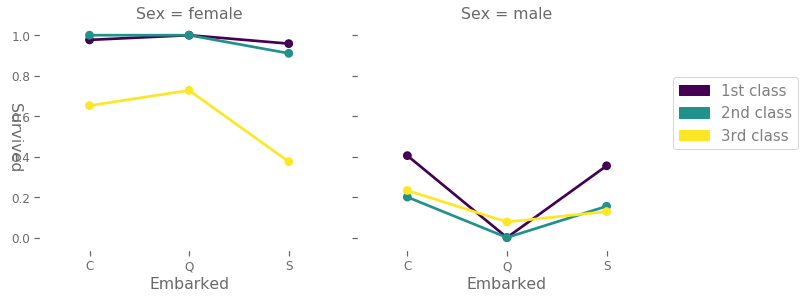

In [17]:
#
p = PrettierPlot()
p.pretty_facet_two_cat_point(
    df=train.recombine_data(train.data, train.target).dropna(subset=["Embarked"]),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    cat_col="Sex",
    aspect=1.0,
    height=5,
    bbox=(1.5, 0.8),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

##### Categorical by numeric

<Figure size 1080x540 with 0 Axes>

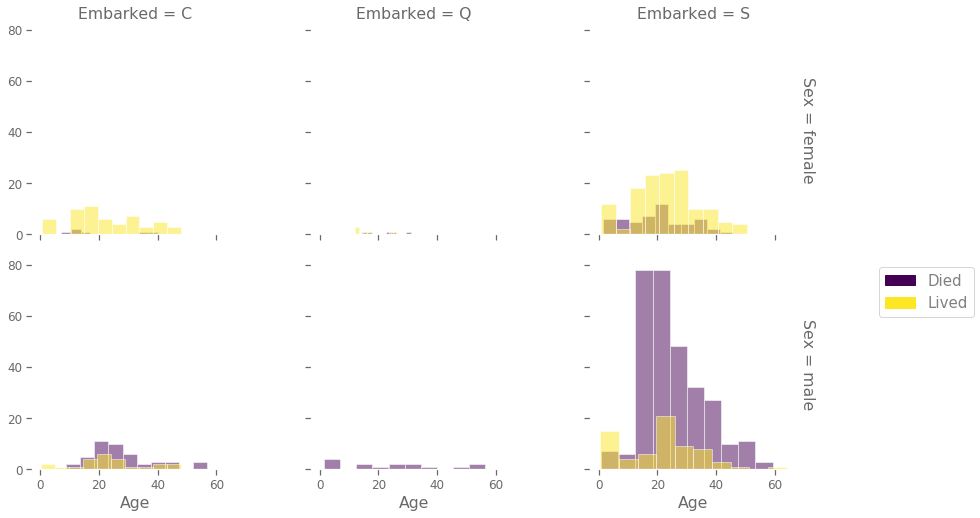

In [18]:
#
p = PrettierPlot()
p.pretty_facet_cat_num_hist(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    num_col="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

<Figure size 1080x540 with 0 Axes>

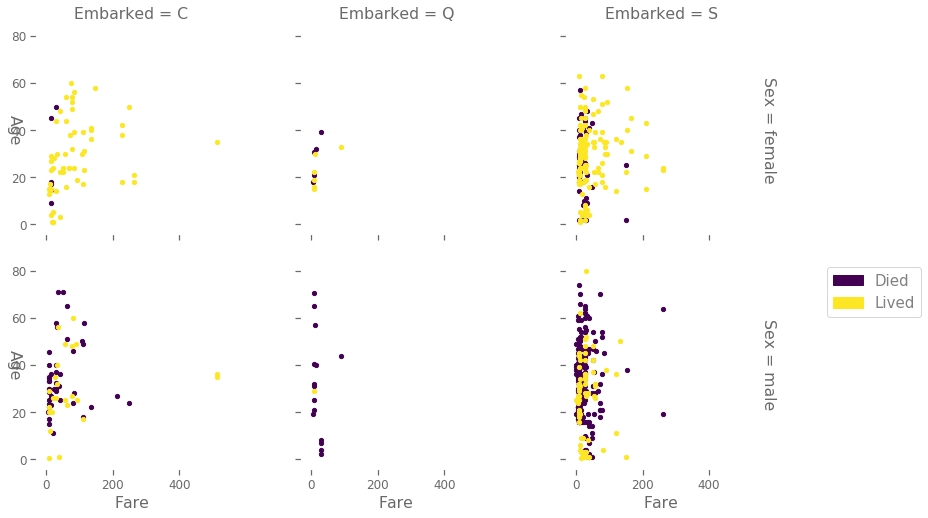

In [19]:
#
p = PrettierPlot(chart_prop=15)
p.pretty_facet_cat_num_scatter(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    x="Fare",
    y="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [20]:
# null score
pd.Series(train.target).value_counts(normalize=True)

0   0.616162
1   0.383838
Name: Survived, dtype: float64

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data


<a id = 'Missing-data'></a>

##### Training

,total missing,percent missing
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


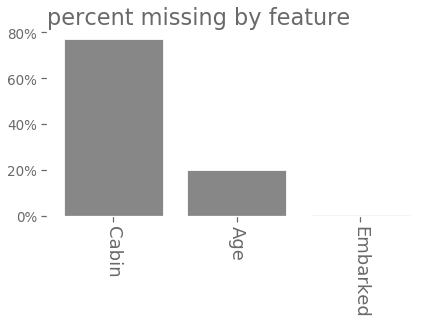

In [21]:
# evaluate missing data
train.eda_missing_summary()

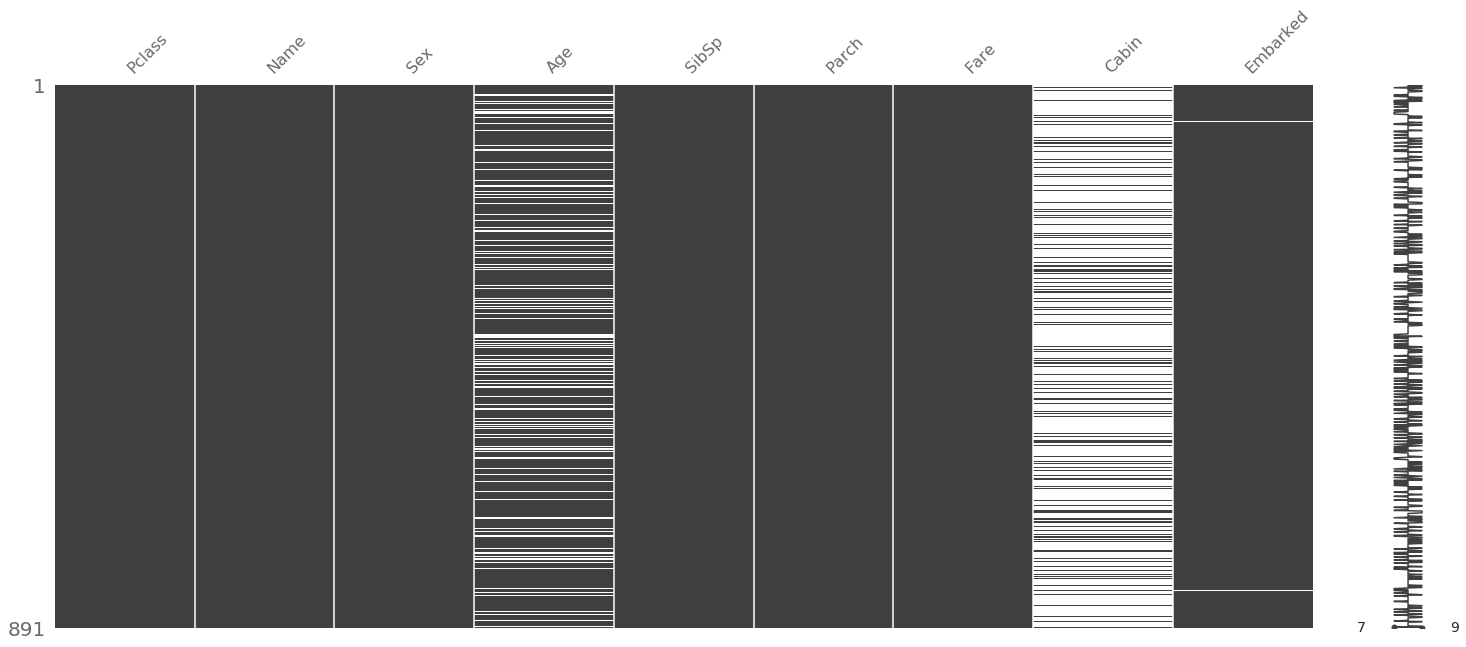

In [22]:
# missingno matrix
msno.matrix(train.data)

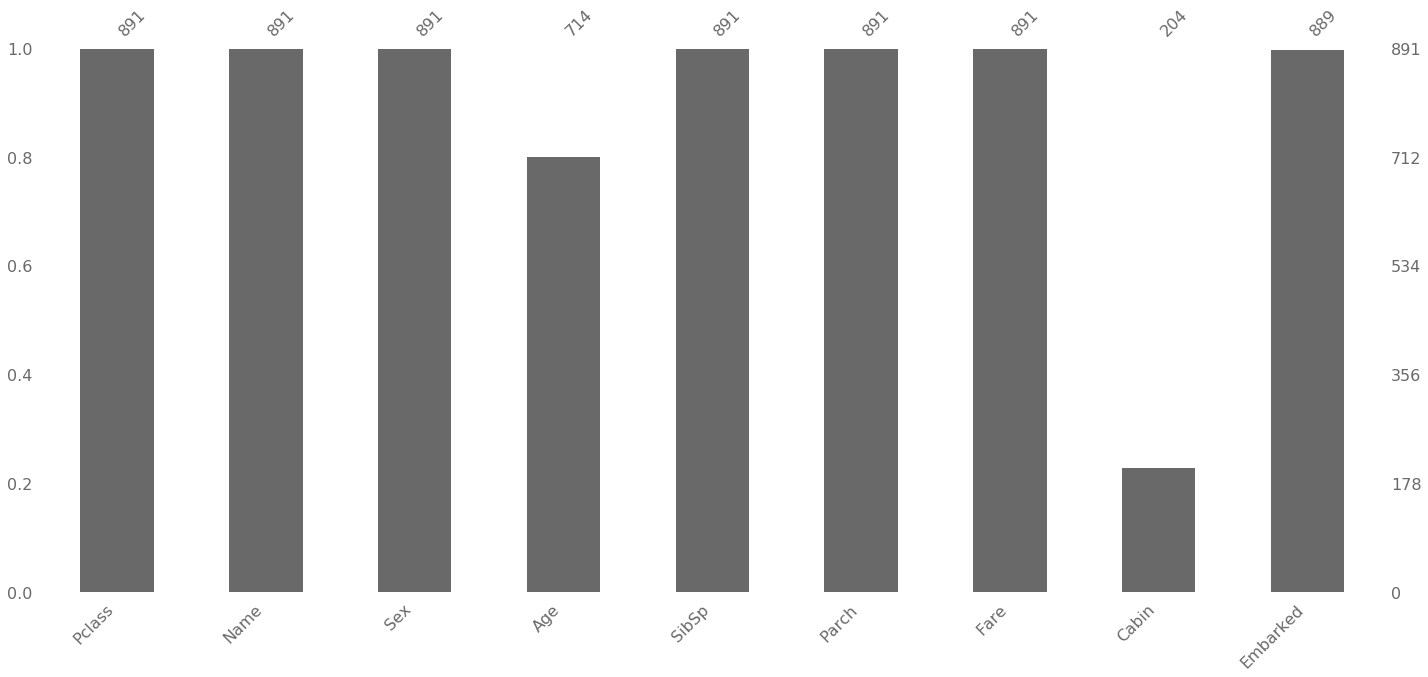

In [23]:
# missingno bar
msno.bar(train.data)

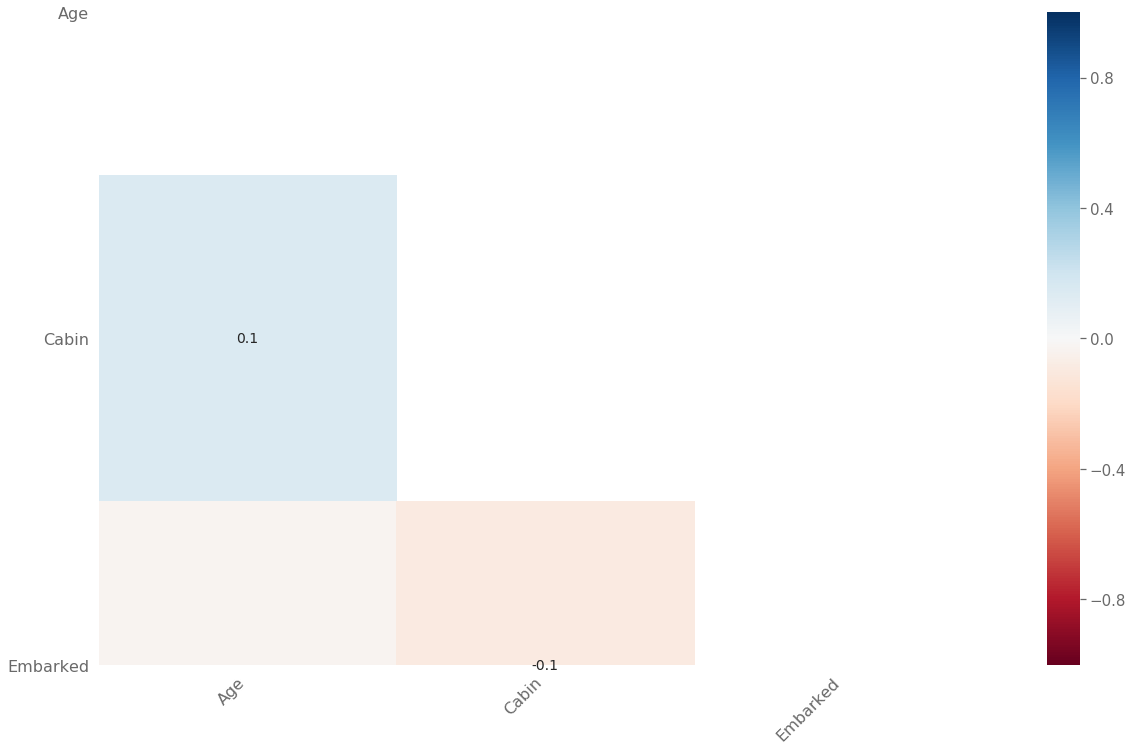

In [24]:
# missingno heatmap
msno.heatmap(train.data)

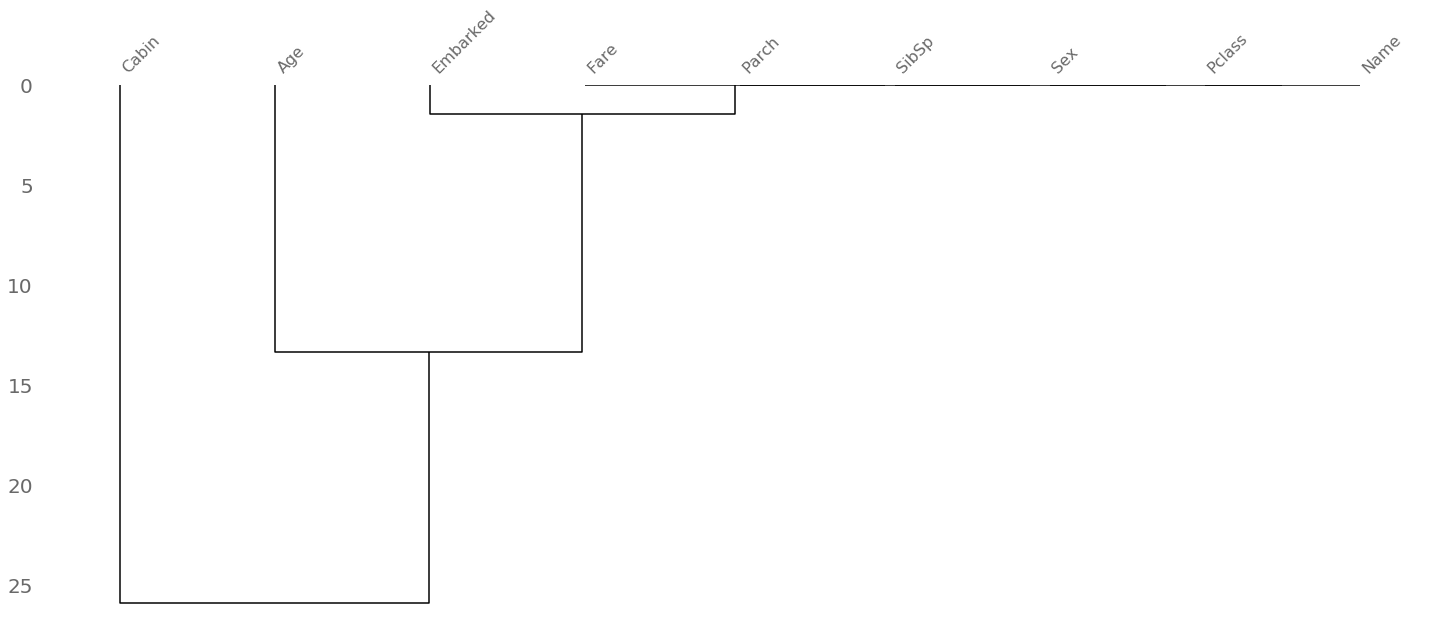

In [25]:
# missingno dendrogram
msno.dendrogram(train.data)

##### Validation

,total missing,percent missing
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


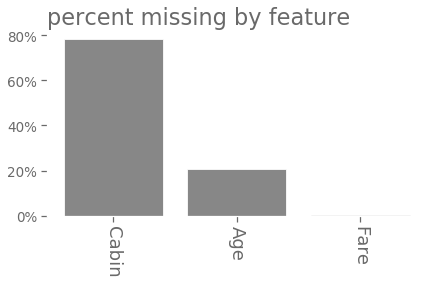

In [26]:
# evaluate missing data
valid.eda_missing_summary()

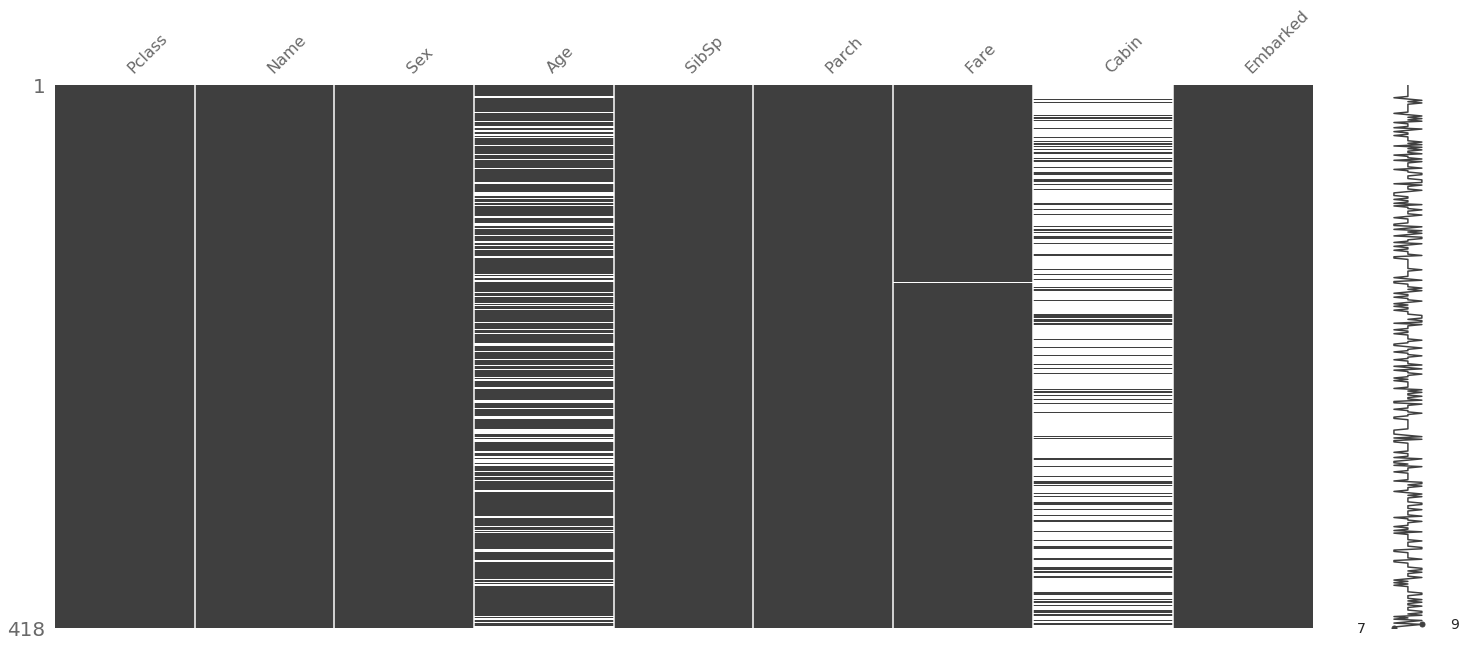

In [27]:
# missingno matrix
msno.matrix(valid.data)

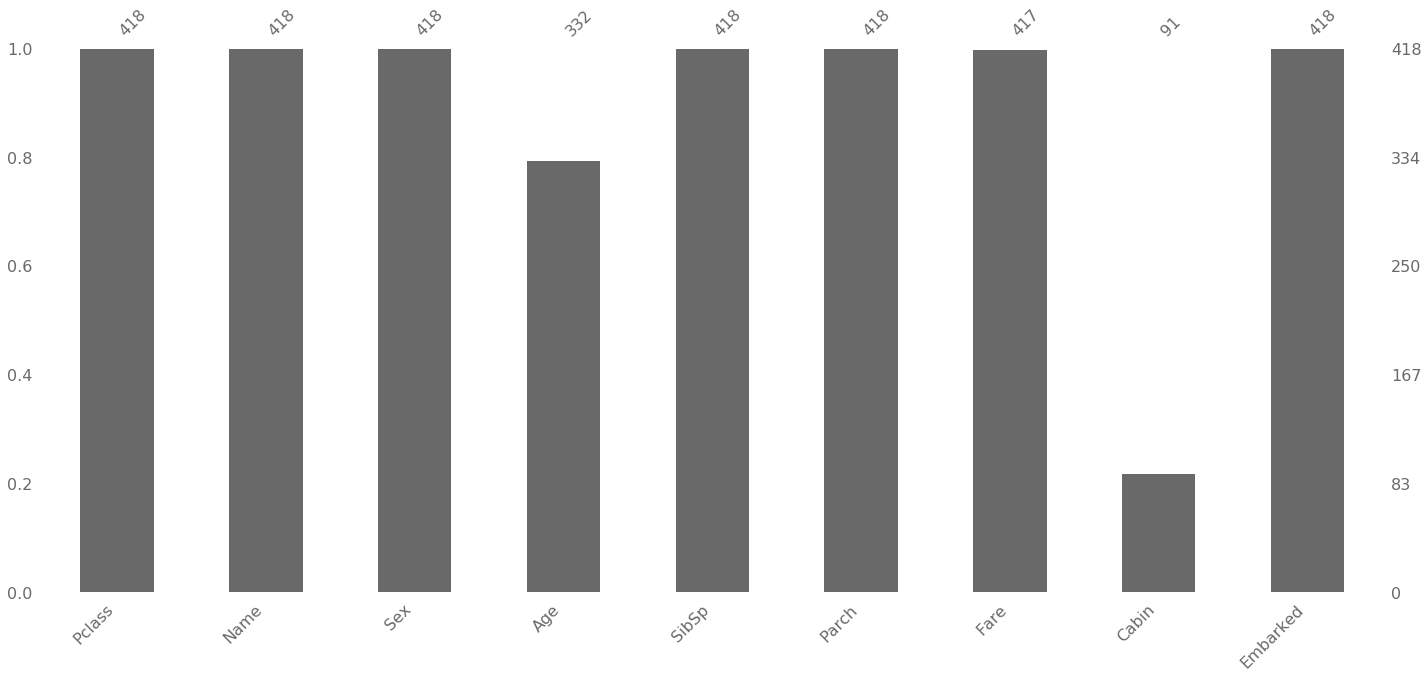

In [28]:
# missingno bar
msno.bar(valid.data)

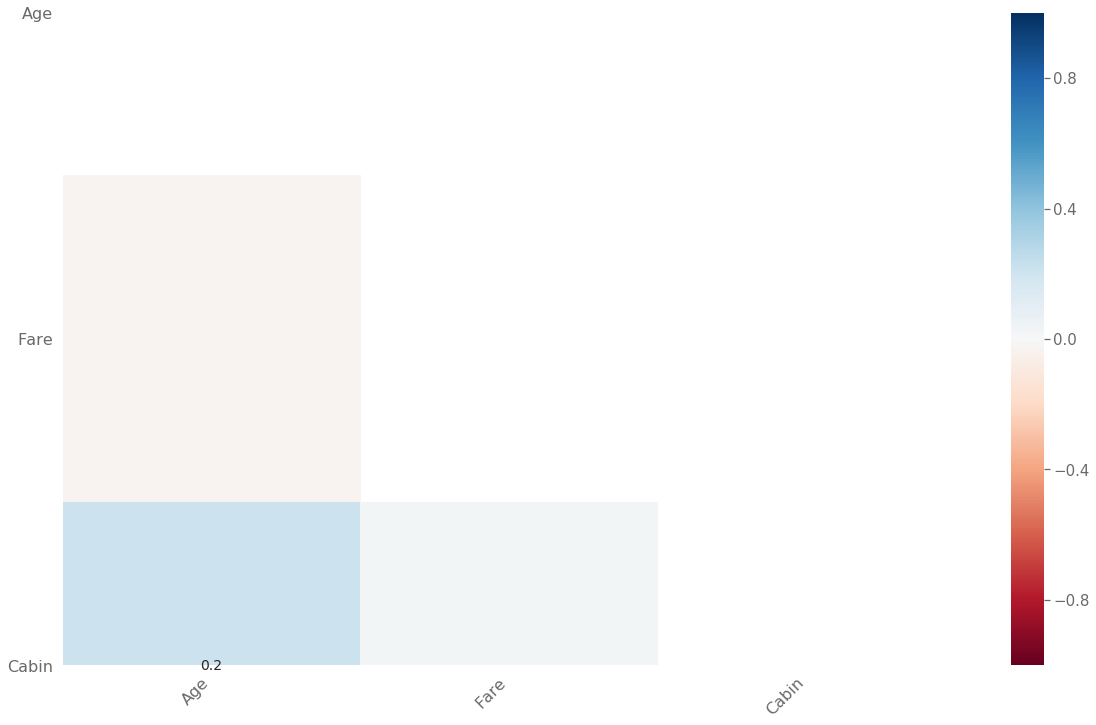

In [29]:
# missingno heatmap
msno.heatmap(valid.data)

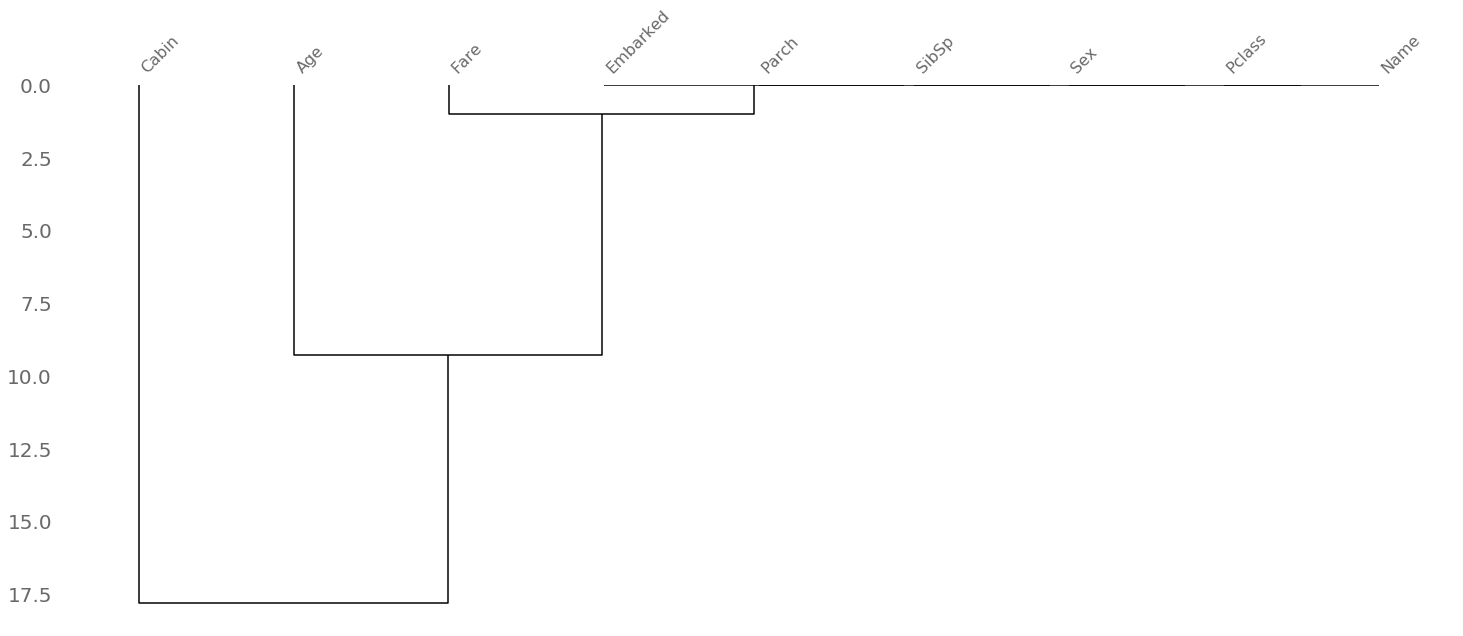

In [30]:
# missingno dendrogram
msno.dendrogram(valid.data)

##### Training vs. validation


In [31]:
# compare feature with missing data
train.missing_col_compare(train=train.data, validation=valid.data)

missing in validation, not train
{'Fare'}

missing in train, not validation
{'Embarked'}


##### Impute

In [32]:
train.data[:5]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.250000,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.283300,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.925000,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.100000,C123,S
4,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.050000,NaN,S


In [33]:
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", pipeline.make_pipeline(
        DataFrameSelector(["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", pipeline.make_pipeline(
        DataFrameSelector(["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", pipeline.make_pipeline(
        DataFrameSelector(["Embarked"]),
        PlayWithPandas(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", pipeline.make_pipeline(
        DataFrameSelector(["Cabin"]),
        PlayWithPandas(impute.SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(["Age","Fare","Embarked","Cabin"]))),
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

In [34]:
train.eda_missing_summary()

no nulls


In [35]:
valid.eda_missing_summary()

no nulls


## Engineering

<a id = 'Engineering'></a>

##### Training

In [36]:
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="category",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("category")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="category",
)

# family size features and binning
train.data["FamilySize"] = pd.to_numeric(train.data["SibSp"]) + pd.to_numeric(train.data["Parch"]) + 1
train.data["FamilySize"] = train.data["FamilySize"].astype("int64")

# update feature_type and drop columns
train.feature_type_update(columns_to_drop=["Name","Cabin"])

##### Validation

In [37]:
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="category",
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("category")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="category",
)

# additional features
valid.data["FamilySize"] = pd.to_numeric(valid.data["SibSp"]) + pd.to_numeric(valid.data["Parch"]) + 1
valid.data["FamilySize"] = valid.data["FamilySize"].astype("int64")

# update feature_type and drop columns
valid.feature_type_update(columns_to_drop=["Name","Cabin"])

## Encoding

<a id = 'Encoding'></a>

##### Training

In [38]:
# counts of unique values in training data string columns
train.data[train.feature_type["categorical"]].apply(pd.Series.nunique, axis=0)

Pclass          3
SibSp           7
Parch           7
Sex             2
Embarked        3
Title           4
CabinQuarter    9
dtype: int64

In [39]:
# print unique values in each categorical columns
for col in train.data[train.feature_type["categorical"]]:
    print(col, np.unique(train.data[col]))

Pclass [1 2 3]
SibSp [0 1 2 3 4 5 8]
Parch [0 1 2 3 4 5 6]
Sex ['female' 'male']
Embarked ['C' 'Q' 'S']
Title [0 1 2 3]
CabinQuarter ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'X']


##### Validation

In [40]:
# counts of unique values in validation data string columns
valid.data[valid.feature_type["categorical"]].apply(pd.Series.nunique, axis=0)

Pclass          3
SibSp           7
Parch           8
Sex             2
Embarked        3
Title           4
CabinQuarter    8
dtype: int64

In [41]:
# print unique values in each categorical columns
for col in valid.data[valid.feature_type["categorical"]]:
    print(col, np.unique(valid.data[col]))

Pclass [1 2 3]
SibSp [0 1 2 3 4 5 8]
Parch [0 1 2 3 4 5 6 9]
Sex ['female' 'male']
Embarked ['C' 'Q' 'S']
Title [0 1 2 3]
CabinQuarter ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'X']


##### Training vs. validation

In [42]:
# identify values that are present in the training data but not the validation data, and vice versa
for col in train.feature_type["categorical"]:
    if col not in ["Name", "Cabin"]:
        train_values = train.data[col].unique()
        valid_values = valid.data[col].unique()

        trainDiff = set(train_values) - set(valid_values)
        valid_diff = set(valid_values) - set(train_values)

        if len(trainDiff) > 0 or len(valid_diff) > 0:
            print("\n\n*** " + col)
            print("Value present in training data, not in validation data")
            print(trainDiff)
            print("Value present in validation data, not in training data")
            print(valid_diff)



*** Parch
Value present in training data, not in validation data
set()
Value present in validation data, not in training data
{9}


*** CabinQuarter
Value present in training data, not in validation data
{'T'}
Value present in validation data, not in training data
set()


##### Encode

In [43]:
#
nominal_columns = ["Embarked","Sex","CabinQuarter","Title"]

ordinal_columns = ["Pclass"]
ordinal_encodings = [
        [0, 1, 2, 3], # Pclass 
    ]

# encode pipeline
encode_pipe = PandasFeatureUnion([
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns),
        PlayWithPandas(preprocessing.OrdinalEncoder(categories=ordinal_encodings)),
    )),
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(nominal_columns),
        PlayWithPandas(preprocessing.OneHotEncoder(drop="first")),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(nominal_columns + ordinal_columns))),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.feature_type_update()
valid.feature_type_update()

## Transformation

<a id = 'Transformation'></a>

### Polynomial features

<a id = 'Polynomial-features'></a>

##### Transform

In [44]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(train.feature_type["numeric"]),
        PlayWithPandas(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(train.feature_type["numeric"]))),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.feature_type_update()
valid.feature_type_update()

### Skew

<a id = 'Skew'></a>

##### Training

In [45]:
# evaluate skew of numeric features - training data
train.skew_summary()

,skew,pct_zero
Age,0.508686,0.000000
Age^2,1.935926,0.000000
FamilySize,2.722848,0.000000
Age*FamilySize,3.055330,0.000000
Fare,4.779253,0.016835
Age*Fare,4.950402,0.016835
FamilySize^2,5.290032,0.000000
Fare*FamilySize,5.440477,0.016835
Fare^2,11.912691,0.016835


##### Validation

In [46]:
# evaluate skew of numeric features - validation data
valid.skew_summary()

,skew,pct_zero
CabinQuarter_T,0.000000,1.000000
Age,0.647999,0.000000
Age^2,1.825275,0.000000
Age*FamilySize,2.795133,0.000000
FamilySize,3.157161,0.000000
Fare,3.678979,0.004785
Fare*FamilySize,4.876821,0.004785
Age*Fare,5.069206,0.004785
FamilySize^2,6.219845,0.000000
Fare^2,9.311510,0.004785


##### Transform

In [47]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(train.feature_type["numeric"]),
        DualTransformer(),
    )),    
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(train.feature_type["numeric"]))),
    )),
])

train.data = skew_pipe.fit_transform(train.data)
valid.data = skew_pipe.transform(valid.data)

train.feature_type_update()
valid.feature_type_update()

### Scale

<a id = 'Scale'></a>

##### Transform

In [48]:
#
scale_pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(train.feature_type["numeric"]),
        PlayWithPandas(preprocessing.StandardScaler())
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(train.feature_type["numeric"]))),
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.feature_type_update()
valid.feature_type_update()

## Outliers


<a id = 'Outliers'></a>

In [49]:
# identify outliers using IQR
trainPipe = pipeline.Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=25,
                iqr_step=1.5,
                features=train.feature_type["numeric"],
                drop_outliers=False,))
    ])
train.data = trainPipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(trainPipe.named_steps["outlier"].outliers_))
print(iqr_outliers)

[]


In [50]:
# identify outliers using Isolation Forest
clf = ensemble.IsolationForest(
    behaviour="new", max_samples=train.data.shape[0], random_state=0, contamination=0.01
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

[ 27 258 305 341 438 678 679 737 745]


In [51]:
# identify outliers using extended isolation forest
trainPipe = pipeline.Pipeline([
    ("outlier",train.ExtendedIsoForest(
                cols=train.feature_type["numeric"],
                n_trees=100,
                sample_size=256,
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = trainPipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(trainPipe.named_steps["outlier"].outliers_))
print(eif_outliers)

TypeError: __init__() got an unexpected keyword argument 'extension_level'

In [ ]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

In [ ]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["Count"] >= 3]

In [ ]:
# remove outlers from predictors and response
outliers = np.array([27, 88, 258, 311, 341, 438, 679, 737, 742])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

# Feature importance

<a id = 'Feature-importance'></a>

In [ ]:
# generate feature importance summary
estimators = [
    lightgbm.LGBMClassifier,
    ensemble.RandomForestClassifier,
    ensemble.GradientBoostingClassifier,
    ensemble.ExtraTreesClassifier,
    ensemble.AdaBoostClassifier,
    xgboost.XGBClassifier,
]

fs = train.FeatureSelector(
    data=train.data, target=train.target, estimators=estimators, rank=True
)
# feature_selector_summary = fs.featureSelectorSuite()
# feature_selector_summary[:20]

In [ ]:
# calculate cross-validation performance
estimators = [
    svm.SVC,
    lightgbm.LGBMClassifier,
    linear_model.LogisticRegression,
    xgboost.XGBClassifier,
    ensemble.RandomForestClassifier,
    ensemble.GradientBoostingClassifier,
    ensemble.AdaBoostClassifier,
    ensemble.ExtraTreesClassifier,
    neighbors.KNeighborsClassifier,
]

cvSummary = fs.feature_selector_cross_val(
    feature_selector_summary = pd.read_csv("featureSelectionSummary_20191028_173422.csv", index_col=0),
    estimators=estimators,
    scoring=["accuracy"],
    n_folds=8,
    step=1,
    n_jobs=8
)

###### Accuracy

In [ ]:
# visualize CV performance for diminishing feature set
fs.featureSelectorResultsPlot(
    metric="accuracy",
    cvSummary= pd.read_csv("cvSummary_20191028_173925.csv", index_col=0),
    feature_selector_summary=pd.read_csv("featureSelectionSummary_20191028_173422.csv", index_col=0),
    title_scale=0.8,
)

In [ ]:
crossValFeaturesDf = fs.createCrossValFeaturesDf(
    metric="accuracy",
    cvSummary= pd.read_csv("cvSummary_20191028_173925.csv", index_col=0),
    feature_selector_summary=pd.read_csv("featureSelectionSummary_20191028_173422.csv", index_col=0),
)
crossValFeaturesDf#[:5]

In [ ]:
cross_val_feature_dict = fs.createCrossValFeaturesDict(
    crossValFeaturesDf=crossValFeaturesDf
)
# cross_val_feature_dict

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

##### Prepare data

In [34]:
#################################################################################
# import training data
df_train, df_valid = data.titanic()
# df_train = pd.read_csv("s3://tdp-ml-datasets/kaggle-titanic/train.csv")
train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    force_to_categorical=["Pclass","SibSp","Parch"],
    target_type="categorical",
)

# import validation data
# df_valid = pd.read_csv("s3://tdp-ml-datasets/kaggle-titanic/test.csv")
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    force_to_categorical=["Pclass","SibSp","Parch"],
)

#################################################################################
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", pipeline.make_pipeline(
        DataFrameSelector(["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", pipeline.make_pipeline(
        DataFrameSelector(["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", pipeline.make_pipeline(
        DataFrameSelector(["Embarked"]),
        PlayWithPandas(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", pipeline.make_pipeline(
        DataFrameSelector(["Cabin"]),
        PlayWithPandas(impute.SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(list(set(train.data.columns).difference(["Age","Fare","Embarked","Cabin"]))),
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

#################################################################################
# feature engineering - training

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="category",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("category")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="category",
)

# family size features
train.data["FamilySize"] = pd.to_numeric(train.data["SibSp"]) + pd.to_numeric(train.data["Parch"]) + 1
train.data["FamilySize"] = train.data["FamilySize"].astype("category")

train.feature_type_update(columns_to_drop=["Name","Cabin"])

#################################################################################
# feature engineering - validation

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="category"
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("category")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="category",
)

# additional features
valid.data["FamilySize"] = pd.to_numeric(valid.data["SibSp"]) + pd.to_numeric(valid.data["Parch"]) + 1
valid.data["FamilySize"] = valid.data["FamilySize"].astype("category")

valid.feature_type_update(columns_to_drop=["Name","Cabin"])

# #################################################################################
# # feature transformation pipeline
# nominal_columns = ["Embarked","Sex","CabinQuarter","Title"]

# ordinal_columns = ["Pclass"]
# ordinal_encodings = [
#         [0, 1, 2, 3], # Pclass 
#     ]

# transform_pipe = PandasFeatureUnion([
#     ("ordinal", pipeline.make_pipeline(
#         DataFrameSelector(ordinal_columns),
#         PlayWithPandas(preprocessing.OrdinalEncoder(categories=ordinal_encodings)),
#     )),
#     ("nominal", pipeline.make_pipeline(
#         DataFrameSelector(nominal_columns),
#         PlayWithPandas(preprocessing.OneHotEncoder(drop="first")),
#     )),
#     ("numeric", pipeline.make_pipeline(
#         DataFrameSelector(train.feature_type["numeric"]),
#         PlayWithPandas(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
# #         DualTransformer(),
#         PlayWithPandas(preprocessing.StandardScaler())
#     )),
#     ("diff", pipeline.make_pipeline(
#         DataFrameSelector(list(set(train.data.columns).difference(nominal_columns + ordinal_columns + train.feature_type["numeric"]))),
#     )),
# ])

# train.data = transform_pipe.fit_transform(train.data)
# valid.data = transform_pipe.transform(valid.data)

# train.feature_type_update()
# valid.feature_type_update()

# #################################################################################
# # remove outliers
# outliers = np.array([27, 88, 258, 311, 341, 438, 679, 737, 742])
# train.data = train.data.drop(outliers)
# train.target = train.target.drop(index=outliers)

# # # accuracy >= 7
# # bestCols = ['Age*Fare','Title_2','Fare*FamilySize','Sex_male','Fare','Pclass','CabinQuarter_X']
# # train.data = train.data[bestCols]
# # valid.data = valid.data[bestCols]

# print('completed')

******************
Categorical label encoding

0 --> 0
1 --> 1


#### Category encoding

- to do
    - feature engineering
        - binning
            - optimal binning (the maxhalfford.github site)
            - categorical features
                - not necessary
            - numeric features
                - for each value, replace with the bin label
        - numeric-specific transformations
            - ratios/quotients
            - sums
            - products
            - differences
    - model evaluation
        - incorrect predictions
            - false positives
            - false negatives
   

__feature selection ideas__

- Single Feature performance
    - determine performance for each feature individually
    - by training a model like XGBoost on each feature seperately or calculating gini coefficients on binned versions of the features.
- forward selection (check out mlxtend)
- backwards elimination (i think i already do this with RFE)
- noise injection to idenitfy unimportant featuers
    - i believe the idea is that any actual features that are less important than the noise featuers can be considered worthless

__cross validation__

- 5 fold
- use stratified k-fold when the test data is not in the future


- http://blog.kaggle.com/2016/04/08/homesite-quote-conversion-winners-write-up-1st-place-kazanova-faron-clobber/
- https://www.kaggle.com/matleonard/categorical-encodings
- http://www.kazanovaforanalytics.com/software.html
- https://github.com/Far0n/xgbfi
- https://towardsdatascience.com/my-secret-sauce-to-be-in-top-2-of-a-kaggle-competition-57cff0677d3c
- https://contrib.scikit-learn.org/categorical-encoding/
- https://github.com/scikit-learn-contrib/categorical-encoding/tree/master/category_encoders
- https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/
- http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/target-encoding.html
- https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b






----------------------------------------------------------------------------------------------------------


if it's a numeic column, but you don't want to bin it
- max level cap? If there there a < X levels in numeric column (or if it's a limited # of ints) just make it orrinal
- pass None to dict
- unique values divided by number of bins
- or is ordinal?

In [43]:
import sklearn.model_selection as model_selection
from collections import defaultdict

X = train.data
X_t = train.target
Y = valid.data

numeric_columns = ["Age","Fare"]
ordinal_columns = ["Pclass","FamilySize","Parch","SibSp"]
nominal_columns = ["CabinQuarter","Embarked","Sex","Title"]

ordinal_encodings = [
        [1, 2, 3], # Pclass
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], # FamilySize
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], # Parch
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], # SibSp
    ]

impute_pipe = PandasFeatureUnion([
    ("catcount", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns + nominal_columns),
        PlayWithPandas(ce.CountEncoder(return_df=False))
    )),
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(nominal_columns),
        PlayWithPandas(preprocessing.OneHotEncoder(drop="first")),
    )),
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns),
        PlayWithPandas(preprocessing.OrdinalEncoder(categories=ordinal_encodings)),
    )),
    ("num3", pipeline.make_pipeline(
        DataFrameSelector(ordinal_columns + nominal_columns + numeric_columns),
        KFoldTargetEncoderTrain(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            nBins = 5,
#             nBins = {"Age" : 5, "Fare" : 10},
            dropBinCols=False,
            dropOriginalCols=True,
        )
    )),
    ("norm", pipeline.make_pipeline(
        DataFrameSelector(numeric_columns),
        PlayWithPandas(preprocessing.QuantileTransformer(output_distribution="normal")),
    )),
    ("uni", pipeline.make_pipeline(
        DataFrameSelector(numeric_columns),
        PlayWithPandas(preprocessing.QuantileTransformer(output_distribution="uniform")),
    )),
    ("select2", pipeline.make_pipeline(
        DataFrameSelector(["Embarked","Age","Fare"]),
    )),
#     ("nu2", pipeline.make_pipeline(
#         DataFrameSelector(["Age","Fare"]),
#         PlayWithPandas(preprocessing.KBinsDiscretizer(n_bins=10, encode="ordinal")),
#     )),
#     ("binar", pipeline.make_pipeline(
#         DataFrameSelector(["Embarked","CabinQuarter"]),
#         PlayWithPandas(ce.BinaryEncoder(return_df=False))
#     )),
])

X = impute_pipe.fit_transform(train.data)
y = impute_pipe.transform(valid.data)
display(X[:10])
display(y[:5])

,Pclass_Count,FamilySize_Count,Parch_Count,SibSp_Count,CabinQuarter_Count,Embarked_Count,Sex_Count,Title_Count,CabinQuarter_B,CabinQuarter_C,CabinQuarter_D,CabinQuarter_E,CabinQuarter_F,CabinQuarter_G,CabinQuarter_T,CabinQuarter_X,Embarked_Q,Embarked_S,Sex_male,Title_1,Title_2,Title_3,Pclass,FamilySize,Parch,SibSp,Pclass_TargetEncoded,FamilySize_TargetEncoded,Parch_TargetEncoded,SibSp_TargetEncoded,CabinQuarter_TargetEncoded,Embarked_TargetEncoded,Sex_TargetEncoded,Title_TargetEncoded,Age_TargetEncoded,Fare_TargetEncoded,Age_5_Bins,Fare_5_Bins,Age_Quantile_normal,Fare_Quantile_normal,Age_Quantile_uniform,Fare_Quantile_uniform,Embarked,Age,Fare
0,491,161,678,209,687,646,577,517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.232190,0.606557,0.349265,0.560241,0.303867,0.348837,0.204348,0.168269,0.342593,0.177305,1.000000,0.000000,-0.695859,-1.373288,0.243258,0.084831,S,22.000000,7.250000
1,216,161,678,209,59,168,314,311,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.679558,0.606557,0.349265,0.560241,0.604167,0.604478,0.750000,0.746988,0.449612,0.689189,3.000000,4.000000,0.710284,1.202387,0.761236,0.885393,C,38.000000,71.283300
2,491,537,678,608,687,646,314,311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.232190,0.302961,0.349265,0.350202,0.303867,0.348837,0.750000,0.746988,0.284916,0.192308,2.000000,1.000000,0.000000,-0.644732,0.500000,0.259551,S,26.000000,7.925000
3,216,161,678,209,59,646,314,311,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.679558,0.606557,0.349265,0.560241,0.604167,0.348837,0.750000,0.746988,0.449612,0.689189,3.000000,4.000000,0.561939,0.989391,0.712921,0.838764,S,35.000000,53.100000
4,491,537,678,608,687,646,577,517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.232190,0.302961,0.349265,0.350202,0.303867,0.348837,0.204348,0.168269,0.449612,0.192308,3.000000,1.000000,0.561939,-0.537371,0.712921,0.295506,S,35.000000,8.050000
5,491,537,678,608,687,77,577,517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.232190,0.302961,0.349265,0.350202,0.303867,0.354839,0.204348,0.168269,0.284916,0.192308,2.000000,1.000000,-0.217152,-0.445194,0.414045,0.328090,Q,25.140620,8.458300
6,216,537,678,608,32,646,577,517,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.679558,0.302961,0.349265,0.350202,0.785714,0.348837,0.204348,0.168269,0.424419,0.689189,4.000000,4.000000,1.628727,0.931325,0.948315,0.824157,S,54.000000,51.862500
7,491,15,118,16,687,646,577,40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,1.000000,3.000000,0.232190,0.300000,0.604167,0.222222,0.303867,0.348837,0.204348,0.703704,0.516129,0.418301,0.000000,2.000000,-2.049130,0.246083,0.020225,0.597191,S,2.000000,21.075000
8,491,102,80,608,687,646,314,311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.232190,0.607143,0.524590,0.350202,0.303867,0.348837,0.750000,0.746988,0.284916,0.418301,2.000000,2.000000,0.050718,-0.228701,0.520225,0.409551,S,27.000000,11.133300
9,184,161,678,209,687,168,314,311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

,Pclass_Count,FamilySize_Count,Parch_Count,SibSp_Count,CabinQuarter_Count,Embarked_Count,Sex_Count,Title_Count,CabinQuarter_B,CabinQuarter_C,CabinQuarter_D,CabinQuarter_E,CabinQuarter_F,CabinQuarter_G,CabinQuarter_T,CabinQuarter_X,Embarked_Q,Embarked_S,Sex_male,Title_1,Title_2,Title_3,Pclass,FamilySize,Parch,SibSp,Pclass_TargetEncoded,FamilySize_TargetEncoded,Parch_TargetEncoded,SibSp_TargetEncoded,CabinQuarter_TargetEncoded,Embarked_TargetEncoded,Sex_TargetEncoded,Title_TargetEncoded,Age_TargetEncoded,Age_5_Bins,Fare_TargetEncoded,Fare_5_Bins,Age_Quantile_normal,Fare_Quantile_normal,Age_Quantile_uniform,Fare_Quantile_uniform,Embarked,Age,Fare
0,491,537,678.000000,608,687,77,577,517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.242415,0.303874,0.343633,0.345424,0.300057,0.384018,0.188870,0.156249,0.444356,3.000000,0.220909,0.000000,0.530875,-0.897105,0.702247,0.184831,Q,34.500000,7.829200
1,491,161,678.000000,209,687,646,314,311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.242415,0.556744,0.343633,0.536130,0.300057,0.339148,0.741364,0.738754,0.385696,4.000000,0.220909,0.000000,1.253257,-1.870116,0.894944,0.030734,S,47.000000,7.000000
2,184,537,678.000000,608,687,77,577,517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.473700,0.303874,0.343633,0.345424,0.300057,0.384018,0.188870,0.156249,0.385696,4.000000,0.180341,1.000000,2.072678,-0.328519,0.980899,0.371260,Q,62.000000,9.687500
3,491,537,678.000000,608,687,646,577,517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.242415,0.303874,0.343633,0.345424,0.300057,0.339148,0.188870,0.156249,0.303937,2.000000,0.180341,1.000000,0.050718,-0.418911,0.520225,0.337640,S,27.000000,8.662500
4,491,102,118.000000,209,687,646,314,311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,0.242415,0.578660,0.549117,0.536130,0.300057,0.339148,0.741364,0.738754,0.327723,1.000000,0.420198,2.000000,-0.695859,-0.198445,0.243258,0.421348,S,22.000000,12.287500


In [ ]:
import itertools  

df = X[["Age","Fare","Age_Quantile_normal","Fare_Quantile_uniform"]]

# create list of tuples containing columns pairs
pairs = list(itertools.product(df, df))

# remove tuples if both items in pair are the same
for x in pairs:
    if len(set(x)) == 1:
        pairs = [i for i in pairs if i != x]

# if two tuples contain the same two items, keep only one
for x in pairs:
    if pairs[0][::-1] in pairs[1:]:
        pairs = pairs[1:]

#
for x in pairs:
    df["{} + {}".format(x[0],x[1])] = df[x[0]] + df[x[1]]
    df["{} / {}".format(x[0],x[1])] = df[x[0]] / df[x[1]]
    df["{} * {}".format(x[0],x[1])] = df[x[0]] * df[x[1]]

df = df.merge(train.target, left_index=True, right_index=True)

XX = df.iloc[:,:-1]
YY = df.iloc[:,-1]

In [ ]:
results = pd.DataFrame(columns=["col","score"])

import xgboost
import sklearn.linear_model as linear_model
for x in XX.columns:
#     obj = linear_model.LogisticRegression()
    obj = xgboost.XGBClassifier()

    obj.fit(XX[[x]], YY)
    preds = obj.predict(XX[[x]])
    
    acc = sum(YY == preds) / len(YY)
    results.loc[len(results)] = [x, acc]
results

###### target

In [ ]:
age = d[["Age"]].drop_duplicates()
ix = np.arange(1, len(age.index)+1)
plt.plot(ix, age)

In [ ]:
fare = d[["Fare"]].drop_duplicates()
ix = np.arange(1, len(fare.index)+1)
plt.plot(ix, fare)

In [ ]:
d[["Age"]].drop_duplicates()

In [ ]:
X.filter(regex="RAD|CHAS")[:20]

## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "linear_model.LogisticRegression": {
        "C": hp.uniform("C", 0.04, 0.1),
        "penalty": hp.choice("penalty", ["l1"]),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "learning_rate": hp.quniform("learning_rate", 0.1, 0.25, 0.01),
        "algorithm": hp.choice("algorithm", ["SAMME"]),
    },
    "ensemble.ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(4, 30, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto"]),
        "criterion": hp.choice("criterion", ["entropy"]),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 4, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
    "neighbors.KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["ball_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 15, dtype=int)),
        "weights": hp.choice("weights", ["uniform"]),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=train.data,
    target=train.target,
    columns=cross_val_feature_dict,
    scoring="accuracy",
    n_folds=2,
    n_jobs=8,
    iters=1,
    verbose=0,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
bayes_optim_summary = pd.read_csv("bayesOptimizationSummary_accuracy_20191028_174038.csv", na_values="nan")
bayes_optim_summary[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary, estimator=estimator)

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
#         chart_prop=15,
        title_scale=0.8
    )

In [ ]:
sample_space = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.sample_plot(sample_space, 1000)

In [ ]:
# pair-wise comparison
p = PrettierPlot(chart_prop=12)
p.pretty_pair_plot_custom(
    df=train.unpack_bayes_optim_summary(bayes_optim_summary, "lightgbm.LGBMClassifier"),
    cols=["colsample_bytree", "learning_rate", "iteration","iterLoss"],
    gradient_col="iteration",
    color=style.style_grey
)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.topBayesOptimModels(bayes_optim_summary=bayes_optim_summary, numModels=1)
top_models

In [ ]:
# classification panel, single model
# estimator = "svm.SVC"; model_iter = 1224
# estimator = 'ensemble.GradientBoostingClassifier'; model_iter = 590
estimator = 'xgboost.XGBClassifier'; model_iter = 1256

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    cm_labels=["Dies", "Survives"],
    n_folds=5,
    title_scale=0.9
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=train.data, y_train=train.target, cm_labels=['Dies', 'Survives'], n_folds=4
        )

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
# estimator = "ensemble.ExtraTreesClassifier"; model_iter = 145
# estimator = "svm.SVC"; model_iter = 135
estimator = "ensemble.GradientBoostingClassifier"; model_iter = 1385

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(model.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=train.data.columns.tolist())

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in train.data.index[:5]:
    train.single_shap_viz_tree(obsIx=i, model=model, data=train.data, target=train.target)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = train.multi_shap_viz_tree(obs_ixs=train.data.index, model=model, data=train.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=train.data.index, model=model, data=train.data
)

In [ ]:
# SHAP dependence plot grid
# grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]
grid_features = ['Age*Fare','Title_2','Fare*FamilySize','Sex_male','Fare','Pclass','CabinQuarter_X']

train.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=train.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Fare",
    color_feature="Sex_male",
    feature_names=train.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Fare",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=train.data.columns,
    )

##### SHAP values - validation data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in valid.data.index[:2]:
    valid.single_shap_viz_tree(obsIx=i, model=model, data=valid.data)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = valid.multi_shap_viz_tree(obs_ixs=valid.data.index, model=model, data=valid.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = valid.multi_shap_value_tree(
    obs_ixs=valid.data.index, model=model, data=valid.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]

valid.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=valid.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

valid.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Age",
    color_feature="Parch",
    feature_names=valid.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = valid.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    valid.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
valid.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=valid.data.columns,
    )

## Submission - standard models

<a id = 'Submission-standard-models'></a>

In [ ]:
{'lightgbm.LGBMClassifier': [778],
 'linear_model.LogisticRegression': [730],
 'xgboost.XGBClassifier': [371],
 'ensemble.RandomForestClassifier': [712],
 'ensemble.GradientBoostingClassifier': [965],
 'ensemble.AdaBoostClassifier': [512],
 'ensemble.ExtraTreesClassifier': [244],
 'svm.SVC': [551],
 'neighbors.KNeighborsClassifier': [576]}

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "lightgbm.LGBMClassifier"; model_iter = 778  #147 survived, 0.775
# estimator = "xgboost.XGBClassifier"; model_iter = 371  #142 survived, 0.765
# estimator = "ensemble.RandomForestClassifier"; model_iter = 712  #144 survived, 0.7655
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 965  #144 survived, 0.7561
estimator = "svm.SVC"; model_iter = 551  # survived, 

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

# fit model and make predictions
yPred = model.predict(valid.data.values)
print(sum(yPred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": yPred})
submit.to_csv("submission.csv", index=False)

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
{'lightgbm.LGBMClassifier': [778],
 'linear_model.LogisticRegression': [730],
 'xgboost.XGBClassifier': [371],
 'ensemble.RandomForestClassifier': [712],
 'ensemble.GradientBoostingClassifier': [965],
 'ensemble.AdaBoostClassifier': [512],
 'ensemble.ExtraTreesClassifier': [244],
 'svm.SVC': [551],
 'neighbors.KNeighborsClassifier': [576]}

In [ ]:
lgb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="lightgbm.LGBMClassifier", model_iter=778)
lr = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="linear_model.LogisticRegression", model_iter=730)
xgb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="xgboost.XGBClassifier", model_iter=371)
rf = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.RandomForestClassifier", model_iter=712)
gb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.GradientBoostingClassifier", model_iter=965)
ada = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.AdaBoostClassifier", model_iter=512)
ext = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.ExtraTreesClassifier", model_iter=244)
svc = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="svm.SVC", model_iter=551)
kn = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="neighbors.KNeighborsClassifier", model_iter=576)

In [ ]:
from vecstack import StackingTransformer
import sklearn.metrics as metrics
# Get your data

# Initialize 1st level estimators
estimators = [('lgb', lgb.model),
              ('lr',lr.model),
              ('xgb',xgb.model),
              ('rf',rf.model),
              ('gb',gb.model),
              ('ada',ada.model),
              ('ext',ext.model),
              ('svc',svc.model),
              ('kn',kn.model),
             ]
              
# Initialize StackingTransformer
stack = StackingTransformer(
    estimators,
    regression=False,
    metric=metrics.accuracy_score,
    verbose=2
)

# Fit
stack = stack.fit(train.data, train.target)

# Get your stacked features
oof_train = stack.transform(train.data)
oof_valid = stack.transform(valid.data)

# Use 2nd level estimator with stacked features

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.pretty_corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)
plt.show()

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=oof_train,
    target=train.target,
    scoring="accuracy",
    n_folds=8,
    n_jobs=8,
    iters=1000,
    verbose=0,
)

In [ ]:
df = pd.DataFrame()

In [ ]:
type(df)

In [ ]:
# read scores summary table
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary_meta,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_prop=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.topBayesOptimModels(
    bayes_optim_summary=bayes_optim_summary_meta, numModels=1
)
top_models

In [ ]:
# classification panel, single model
estimator = "svm.SVC"; model_iter = 135
# estimator = 'ensemble.GradientBoostingClassifier'; model_iter = 590
# estimator = 'xgboost.XGBClassifier'; model_iter = 380

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Submission - stacked models

<a id = 'Submission-stacked-models'></a>

In [ ]:
# best second level learning model
# estimator = "lightgbm.LGBMClassifier"; model_iter = 876 #0.75119
# estimator = "xgboost.XGBClassifier"; model_iter = 821, #0.779
# estimator = "ensemble.RandomForestClassifier"; model_iter = 82 
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 673 #0.77511
estimator = "svm.SVC"; model_iter = 538 # 0.77511

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

model.fit(oof_train, train.target.values)
yPred = model.predict(oof_valid)
print(sum(yPred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": yPred})
submit.to_csv("submission.csv", index=False)